In [25]:
import csv
import logging

def readPPMSDataFile(filename):
    rv = {}
    with open(filename, newline="") as f:
        r = csv.reader(f, delimiter=',')
        hdr = []
        data = []
        section = None
        for row in r:
            if row[0].lower() == '[Header]'.lower():
                section = hdr
            elif row[0].lower() == '[Data]'.lower():
                section = data
            elif section is None:
                logging.warning("No section found: %s", row)
            else:
                section.append(row)
    rv['header'] = hdr
    rv['data'] = data
    return rv

def getDataColumn(df, name, prefixMatching=True):
    names = df['data'][0]
    colIdx = None
    colName = None
    for i,n in enumerate(names):
        if ((prefixMatching and len(n)>=len(name) and n[0:len(name)].lower()==name.lower()) or
            (not prefixMatching and n.lower() == name.lower())):
            if colIdx is None:
                colIdx = i
                colName = n
            else:
                logging.warning("Multiple matching columns: %s, %s", colName, n)
    if colIdx is None:
        return None
    rv = []
    for r in df['data'][1:]:
        if len(r) > colIdx:
            try:
                rv.append(float(r[colIdx]))
            except ValueError:
                rv.append(r[colIdx])
        else:
            logging.warning("Short row found: %s", r)
    return rv

cDF = readPPMSDataFile("140307 DCWb1131 Na1.9IrO3.dat")
T = getDataColumn(cDF,"Temp")
M = getDataColumn(cDF,"M-DC")
MT = [x for x in zip(*[T,M])]
MT2 = []
M2 = []
invM2 = []
M0 = 0.0000675
T2 = []
for i in MT:
    if isinstance(i[1],float):
        MT2.append(i)
        M2.append(i[1]-M0)
        T2.append(i[0])
        invM2.append(1/(i[1]-M0))
print(MT2)

[(1.98731265, 0.00428542130337945), (1.98485865, 0.00433628733414888), (1.98563805, 0.00432868991646879), (2.02245045, 0.00433430812171383), (3.0497427, 0.00424718148926984), (4.06071115, 0.00417740329583814), (5.0352571, 0.00410962771443175), (6.0357244, 0.00406075572301275), (7.03658435, 0.00401721561682975), (8.03236485, 0.00397484867322257), (9.03794, 0.00395491288222481), (10.03708505, 0.0039269573175721), (11.0464511, 0.00391121249720466), (12.0390563, 0.00391500790389594), (13.03723095, 0.00392015953804397), (14.0367732, 0.00390589474126847), (15.04004525, 0.00392637335061785), (16.0456419, 0.0039584767248012), (17.04226115, 0.00395770552241866), (18.0405865, 0.00393710063920686), (19.0365572, 0.0039381083263976), (20.04451375, 0.00391167914268951), (21.04722785, 0.00391122296780788), (22.03955175, 0.00389877436849977), (23.0404234, 0.00386903932262218), (24.0480213, 0.00386445161897863), (25.0422907, 0.00383278301741268), (26.04000855, 0.00383095531503), (27.0396309, 0.00379315

<IPython.core.display.Javascript object>


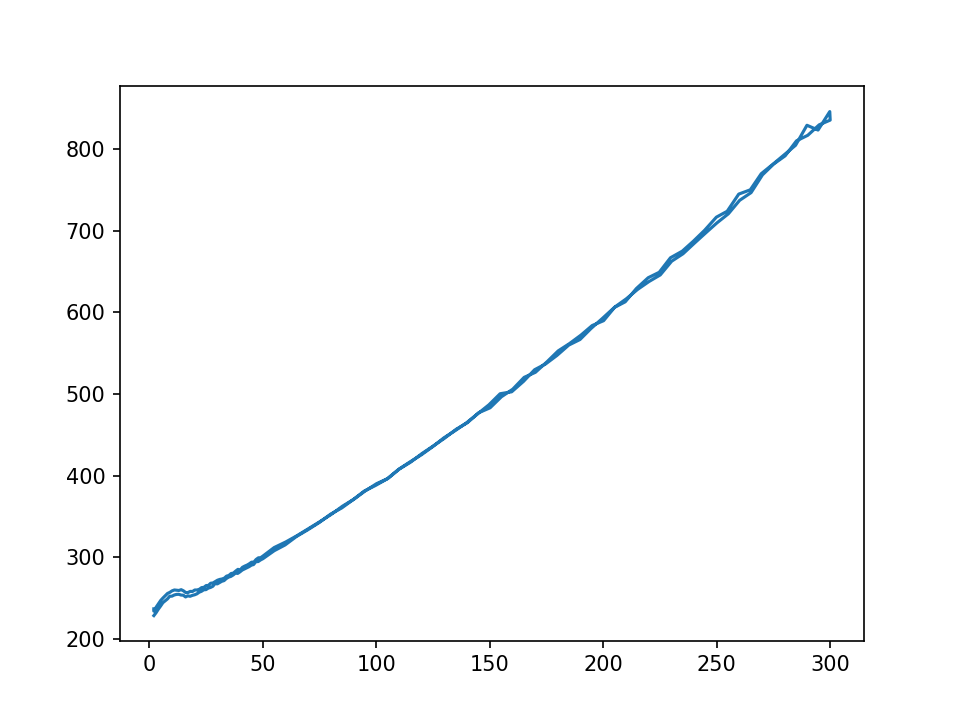

In [26]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.figure()
plt.plot(T2,invM2)

In [27]:
from scipy.stats import linregress
print(linregress(T2,invM2))

LinregressResult(slope=1.9723891753106908, intercept=211.04818948119464, rvalue=0.9958535847653246, pvalue=3.758379812141841e-209, stderr=0.012772364856249096)


In [33]:
def linfitaboveT(MT, Tmin, M0):
    fitDataX = []
    fitDataY = []
    for r in MT:
        if r[0] >= Tmin:
            fitDataX.append(r[0])
            fitDataY.append(1/(r[1]-M0))
    return linregress(fitDataX,fitDataY)

print(linfitaboveT(MT2,0,0.0000675))

LinregressResult(slope=1.9723891753106908, intercept=211.04818948119464, rvalue=0.9958535847653246, pvalue=3.758379812141841e-209, stderr=0.012772364856249096)


In [51]:
def findM0(MT, Tmin):
    Mlower = -1
    Mhigher = 1
    Rlower = linfitaboveT(MT, Tmin, Mlower).rvalue
    Rhigher = linfitaboveT(MT, Tmin, Mhigher).rvalue
    while abs(Mhigher-Mlower) > 1e-6:
        Mmid = (Mlower+Mhigher)/2
        Rmid = linfitaboveT(MT, Tmin, Mmid).rvalue
        if Rlower > Rhigher:
            Mhigher = Mmid
            Rhigher = Rmid
        else:
            Mlower = Mmid
            Rlower = Rmid
    M0 = (Mlower+Mhigher)/2
    return M0
print(findM0(MT, 100), findM0(MT,150), findM0(MT,200))

-0.0005869865417480469 -0.0006108283996582031 -0.0004887580871582031


In [52]:
def cleanedUpMT(fn):
    cDF = readPPMSDataFile(fn)
    T = getDataColumn(cDF,"Temp")
    M = getDataColumn(cDF,"M-DC")
    MT = [x for x in zip(*[T,M])]
    MT2 = []
    for i in MT:
        if isinstance(i[1],float):
            MT2.append(i)
    return MT2

print(findM0(cleanedUpMT("140305 DCWb1132 Na1.8IrO3.dat"), 150))
print(findM0(cleanedUpMT("140307 DCWb1131 Na1.9IrO3.dat"), 150))
print(findM0(cleanedUpMT("140309 DCWb1133 Na1.7IrO3.dat"), 150))


-4.76837158203125e-07
-0.0006108283996582031
-0.00013685226440429688
